# Style Transfer with Deep Learning

This notebook demonstrates style transfer, an application of deep learning, where the content of one image is combined with the style of another. The technique, popularized by Gatys et al.'s 2015 paper, uses a loss function that matches the content and style in a deep network's feature space, and optimizes the image pixels via gradient descent.

SqueezeNet, a compact and accurate deep learning model, is used as the feature extractor, making this implementation feasible to run on a CPU.

In [1]:
from torch.autograd import Variable
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torchvision.transforms as T
import PIL
import matplotlib.pyplot as plt

The following code utilizes two constants, `SQUEEZENET_MEAN` and `SQUEEZENET_STD`. 
`SQUEEZENET_MEAN` is the mean of the ImageNet dataset's RGB channels, and `SQUEEZENET_STD` is the corresponding standard deviation. Both are used to normalize and denormalize the images during preprocessing and deprocessing, aligning the image data with the format the SqueezeNet model was trained on.

In [2]:
SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

## Helper Functions

We define a set of helper functions to assist in our style transfer process:

* `preprocess(img, size=512)`: This function processes the input image by converting it to a tensor and normalizing it using the pre-defined constants. The output is a tensor that can be passed to the model.

* `deprocess(img)`: This function reverses the preprocessing step, converting a tensor back into an image. The output is an image that can be viewed or saved to file.

* `rescale(x)`: This function rescales an input tensor so that its values lie in the range [0, 1]. This is necessary for viewing the tensor as an image.

* `extract_features(x, cnn)`: This function passes an image through the model and extracts the features from specified layers. These features can be used to compute the content and style loss.

* `gram_matrix(features, normalize=True)`: This function computes the Gram matrix of a set of features. The Gram matrix captures the style of an image.

In [3]:
# Preprocess the image
def preprocess(img, size=512):
    img = img.convert("RGB")
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled


# Define method to extract features from the image using the CNN
def extract_features(x, cnn):
    features = []
    prev_feat = x
    for i, module in enumerate(cnn._modules.values()):
        next_feat = module(prev_feat)
        features.append(next_feat)
        prev_feat = next_feat
    return features

# Define the Gram matrix computation
def gram_matrix(features, normalize=True):
    N, C, H, W = features.size()
    features = torch.reshape(features, (N, C, -1))
    if normalize == True:
        gram = torch.bmm(features, features.permute(0, 2, 1))/float(H*W*C)
    else:
        gram = torch.bmm(features, features.permute(0, 2, 1))
    return gram

# Define method to deprocess the image
def deprocess(img):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[
                    1.0 / s for s in SQUEEZENET_STD.tolist()]),
        T.Normalize(
            mean=[-m for m in SQUEEZENET_MEAN.tolist()], std=[1, 1, 1]),
        T.Lambda(rescale),
        T.ToPILImage(),
    ])
    return transform(img)

## Loss Functions

In order to generate an image that reflects the content of one image and the style of another, we incorporate both in our loss function. Deviations from the content of the content image and deviations from the style of the style image are penalized. This hybrid loss function is used to perform gradient descent not on the parameters of the model but on the pixel values of the original image.

1. **Content Loss**

Content loss measures how much the feature map of the generated image differs from the feature map of the source image. We are interested in the content representation of one layer of the network that has feature maps. The content loss is given by the weighted sum of the squared differences between the feature map for the current image (F) and the feature map for the content source image (P).

2. **Style Loss**

The style loss is defined by computing the Gram matrix (G), which represents the correlations between the responses of each filter. The Gram matrix is an approximation to the covariance matrix. We want the activation statistics of our generated image to match the activation statistics of our style image, and matching the (approximate) covariance is one way to achieve that. The style loss for a layer is the weighted Euclidean distance between the two Gram matrices of the current image and the source style image.

3. **Total Variation Loss**

It's beneficial to encourage smoothness in the image. This is achieved by adding another term to our loss that penalizes wiggles or total variation in the pixel values. This concept is widely used in many computer vision tasks as a regularization term. The total variation is computed as the sum of the squares of differences in the pixel values for all pairs of pixels that are next to each other (horizontally or vertically). The total summed loss is then weighted by the total variation weight.

In [4]:
class ContentLoss(nn.Module):
    def forward(self, content_weight, content_current, content_original):
        loss = content_weight * torch.sum(torch.square(content_current - content_original))
        return loss
    
class StyleLoss(nn.Module):
    def gram_matrix(self, features, normalize=True):
        N, C, H, W = features.size()
        features = torch.reshape(features, (N, C, -1))
        if normalize == True:
            gram = torch.bmm(features, features.permute(0, 2, 1))/float(H*W*C)
        else:
            gram = torch.bmm(features, features.permute(0, 2, 1))
        return gram


    def forward(self, feats, style_layers, style_targets, style_weights):
        loss = 0
        for i in range(len(style_layers)):
            gram_mat = self.gram_matrix(feats[style_layers[i]])
            loss += style_weights[i] * \
                torch.sum(torch.pow(gram_mat - style_targets[i], 2))
        return loss
    
class TotalVariationLoss(nn.Module):
    def forward(self, img, tv_weight):
        w_var = torch.sum(torch.pow(img[:,:,:,:-1] - img[:,:,:,1:], 2))
        h_var = torch.sum(torch.pow(img[:,:,:-1,:] - img[:,:,1:,:], 2))

        loss = tv_weight * (w_var + h_var)

        return loss

## Main Function: style_transfer()

This is the main function that performs the task of neural style transfer. It takes in various parameters including the content image, style image, sizes of images, layers to use for content and style representations, weights for content, style, and total variation loss, the CNN model, and the data type.

**Parameters**:

* `name`: Name of the result image.
* `content_image`: Path to the content image file.
* `style_image`: Path to the style image file.
* `image_size`: Size of the content image.
* `style_size`: Size of the style image.
* `content_layer`: Index of layer to use for content loss.
* `content_weight`: Weighting factor for content loss.
* `style_layers`: Indices of layers to use for style loss.
* `style_weights`: List of weighting factors for style loss corresponding to style_layers.
* `tv_weight`: Weighting factor for total variation loss.
* `content_loss`: Instance of content loss class.
* `style_loss`: Instance of style loss class.
* `tv_loss`: Instance of total variation loss class.
* `cnn`: Pretrained CNN model for feature extraction.
* `dtype`: Data type to use for tensors.
* `init_random`: If True, initializes the output image to random noise.

In [5]:
def style_transfer(name, content_image, style_image, image_size, style_size, content_layer, content_weight,
                   style_layers, style_weights, tv_weight, content_loss, style_loss, tv_loss, cnn, dtype,
                   init_random=False):
    # Extract features for the content image
    content_img = preprocess(PIL.Image.open(content_image), size=image_size)
    content_img_var = Variable(content_img.type(dtype))
    feats = extract_features(content_img_var, cnn)
    content_target = feats[content_layer].clone()

    # Extract features for the style image
    style_img = preprocess(PIL.Image.open(style_image), size=style_size)
    style_img_var = Variable(style_img.type(dtype))
    feats = extract_features(style_img_var, cnn)
    style_targets = []
    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))

    # Initialise output image to content image or noise
    if init_random:
        img = torch.Tensor(content_img.size()).uniform_(0, 1)
    else:
        img = content_img.clone().type(dtype)

    img_var = Variable(img, requires_grad=True)

    # Set up optimization hyperparameters
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 180

    optimizer = torch.optim.Adam([img_var], lr=initial_lr)

    for t in range(200):
        if t < 190:
            img.clamp_(-1.5, 1.5)
        feats = extract_features(img_var, cnn)

        optimizer.zero_grad()
        cont_loss = content_loss(
            content_weight, feats[content_layer], content_target)
        st_loss = style_loss(feats, style_layers,
                             style_targets, style_weights)
        t_loss = tv_loss(img_var, tv_weight)
        loss = cont_loss + st_loss + t_loss
        loss.backward(retain_graph=True)

        if t == decay_lr_at:
            optimizer = torch.optim.Adam([img_var], lr=decayed_lr)

        optimizer.step()

    # Deprocess the images for plotting
    content_img = deprocess(content_img.cpu())
    style_img = deprocess(style_img.cpu())
    img = deprocess(img_var.data.cpu())

    # Plotting
    plt.figure(figsize=(10, 5))

    # Content image
    plt.subplot(1, 3, 1)
    plt.imshow(content_img)
    plt.axis('off')
    plt.title('Content Image')

    # Style image
    plt.subplot(1, 3, 2)
    plt.imshow(style_img)
    plt.axis('off')
    plt.title('Style Image')

    # Output image
    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Output Image')

    plt.show()


    return img

In [6]:
# Load model and loss classes
content_loss = ContentLoss()
style_loss = StyleLoss()
tv_loss = TotalVariationLoss()
dtype = torch.FloatTensor
cnn = torchvision.models.squeezenet1_1(pretrained=True).features

/Users/yennybae/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/yennybae/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Define parameters
params = {
    'name': 'composition_vii_tubingen',
    'content_image': 'images/dog.png',
    'style_image': 'images/starry_night.jpg',
    'image_size': 192,
    'style_size': 512,
    'content_layer': 3,
    'content_weight': 5e-2,
    'style_layers': (1, 4, 6, 7),
    'style_weights': (40000, 1000, 24, 2),
    'tv_weight': 5e-2,
    'content_loss': content_loss,
    'style_loss': style_loss,
    'tv_loss': tv_loss,
    'cnn': cnn,
    'dtype': dtype
}

params2 = {
    'name': 'composition_vii_tubingen',
    'content_image': 'images/dog.png',
    'style_image': 'images/monet.jpeg',
    'image_size': 192,
    'style_size': 512,
    'content_layer': 3,
    'content_weight': 5e-2,
    'style_layers': (1, 4, 6, 7),
    'style_weights': (40000, 1000, 24, 2),
    'tv_weight': 5e-2,
    'content_loss': content_loss,
    'style_loss': style_loss,
    'tv_loss': tv_loss,
    'cnn': cnn,
    'dtype': dtype
}

params3 = {
    'name': 'composition_vii_tubingen',
    'content_image': 'images/dog.png',
    'style_image': 'images/scream.jpeg',
    'image_size': 192,
    'style_size': 512,
    'content_layer': 3,
    'content_weight': 5e-2,
    'style_layers': (1, 4, 6, 7),
    'style_weights': (40000, 1000, 24, 2),
    'tv_weight': 5e-2,
    'content_loss': content_loss,
    'style_loss': style_loss,
    'tv_loss': tv_loss,
    'cnn': cnn,
    'dtype': dtype
}

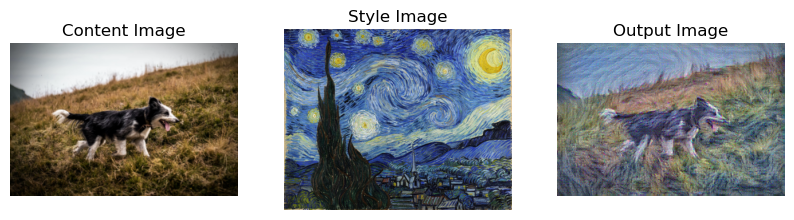

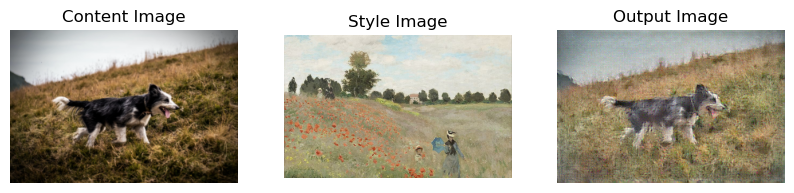

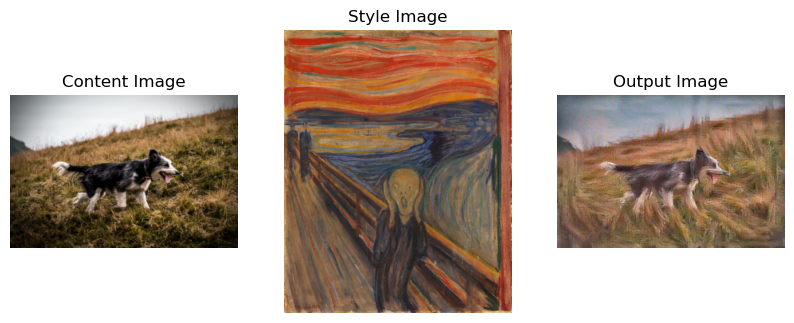

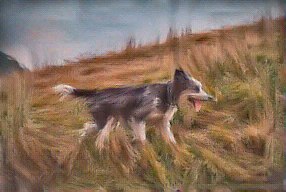

In [8]:
# Call the main function with defined parameters
style_transfer(**params)
style_transfer(**params2)
style_transfer(**params3)